In [202]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
# def mad(dat): #median absolute deviation
#     return np.median(np.absolute(dat - np.median(dat)))

# def LMCdisk_cart(ra, dec):
    
#     '''
#     Calculate the position of stars in the LMC disk plane with 
#     center at the LMC center in cartesian coordinates (x, y).
#     This also calculates the distance to the individual stars.
    
#     This follows van der Marel and Cioni 2001 
    
#     Input
#     - ra: right ascension of stars
#     - dec: declination of stars
    
#     Output
#     - x_m: x coordinate
#     - y_m: y coordinate
#     - dis: distance to LMC star
#     '''
#     alph0 = np.radians(82.25) #right ascension of center of LMC
#     delt0 = np.radians(-69.50) #declination of center of LMC
#     pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
#     io = np.radians(25.86) #27.81 #inclination of LMC disk
#     d0 = 49.90 #distance to center of LMC
    
#     #convert to radians
#     ra = np.radians(ra)
#     dec = np.radians(dec)
#     sd = np.sin(delt0)
#     cd = np.cos(delt0)
    
#     cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
#     srcp = -np.cos(dec)*np.sin(ra-alph0)
#     srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
#     dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
#     x_m = dis*srcp
#     y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
#     return x_m, y_m, dis

# #calculate absolute mag
# def absmag(magnitude,distance):
#     '''
#     - magnitude: apparent magnitude of star
#     - distance: distance to star in kpc
#     Calculate the absolute magnitude of star
#     '''
#     absm = []
#     absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
#     absm = np.squeeze(np.array(absm))
#     return absm

# def sal(MH,aM):
#     '''
#     Calculate the Salaris correction to the overall metallicity
#     '''
#     return MH + np.log(0.638*(10**(aM))+0.362)

In [26]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

In [30]:
max(r13['LOGG'])

2.984853

In [35]:
krgb = np.where((kasc['LOGG_FIT']<max(r13['LOGG']))&(kasc['TEFF_FIT']>min(r13['TEFF']))&
         (kasc['TEFF_FIT']<max(r13['TEFF'])))
kasc_rgb = kasc[krgb]

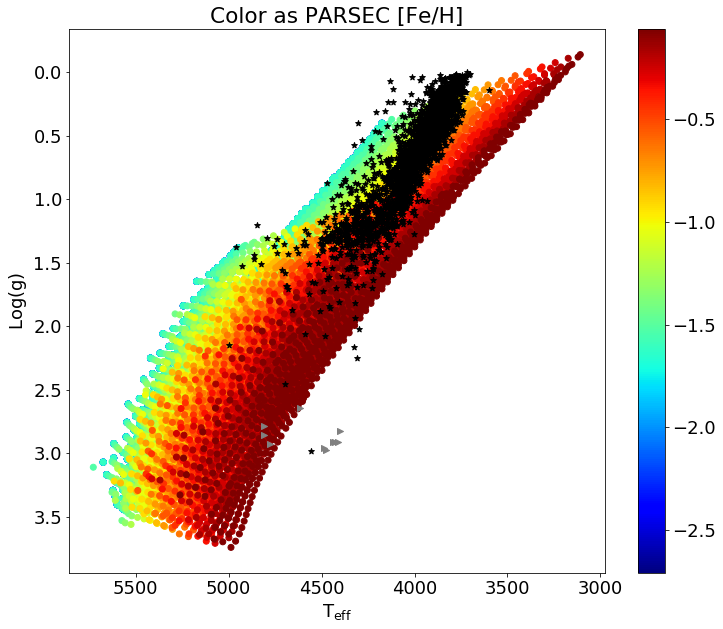

In [158]:
plt.figure(figsize=[12,10])
plt.scatter(10**parsec['logTe']+75,parsec['logg'],c=np.log10(parsec['Zini']/0.02),cmap='jet',label='PARSEC')
plt.colorbar()
plt.scatter(r13['TEFF'],r13['LOGG'],c='k',marker='*',label='R13')
plt.scatter(kasc_rgb['TEFF_FIT'][kasc_rgb['K_MAG_2m']>=12.0],kasc_rgb['LOGG_FIT'][kasc_rgb['K_MAG_2m']>=12.0],c='gray',marker='>',label='APOKASC')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel(r'$\mathrm{T_{eff}}$')
plt.ylabel(r'$\mathrm{Log(g)}$')
plt.title(r'Color as PARSEC [Fe/H]')
plt.show()

In [27]:
kasc.columns

ColDefs(
    name = 'KEPLER_ID'; format = '20A'
    name = 'KEPLER_INT'; format = 'K'
    name = '2MASS_ID'; format = '20A'
    name = 'LOC_ID'; format = '20A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'RA_PM'; format = 'D'
    name = 'DEC_PM'; format = 'D'
    name = 'UCAC_PM_RA'; format = 'E'
    name = 'UCAC_PM_RA_ERR'; format = 'E'
    name = 'UCAC_PM_DEC'; format = 'E'
    name = 'UCAC_PM_DEC_ERR'; format = 'E'
    name = 'GAIA_L'; format = 'E'
    name = 'GAIA_B'; format = 'E'
    name = 'GAIA_ECLIPTIC_LONGITUDE'; format = 'E'
    name = 'GAIA_ECLIPTIC_LATITUTE'; format = 'E'
    name = 'GAIA_PARALLAX'; format = 'E'; unit = 'Angle[mas]'
    name = 'GAIA_PARALLAX_ERR'; format = 'E'; unit = 'Angle[mas]'
    name = 'GAIA_SOURCE_ID_DR2'; format = '23A'
    name = 'GAIA_PARALLAX_DR2'; format = 'D'
    name = 'GAIA_PARALLAX_ERROR_DR2'; format = 'D'
    name = 'GAIA_PMRA_DR2'; format = 'D'
    name = 'GAIA_PMRA_ERROR_DR2'; format = 'D'
    name = 'GAIA_PMDE

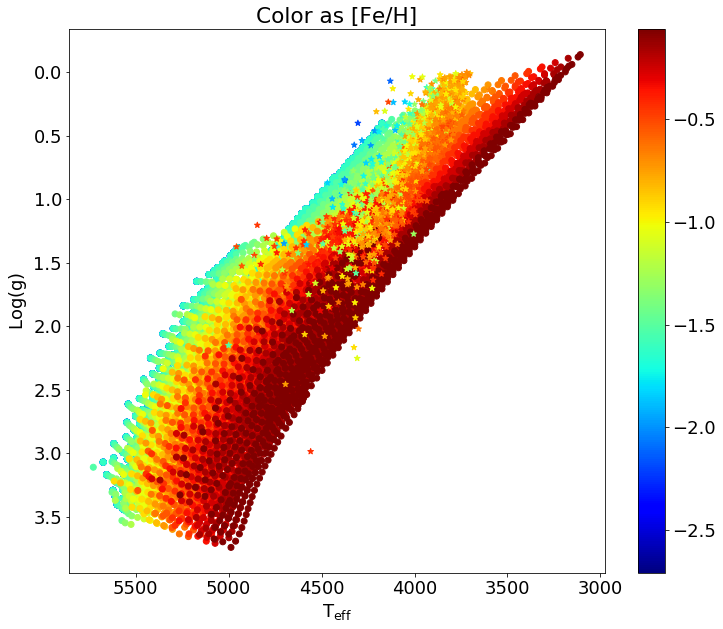

In [203]:
#####################
### Isochrone CMD ###
#####################

plt.figure(figsize=[12,10])
plt.scatter(10**parsec['logTe']+75,parsec['logg'],c=np.log10(parsec['Zini']/0.02),cmap='jet')
plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],vmin=np.min(np.log10(parsec['Zini']/0.02)),
            vmax=np.max(np.log10(parsec['Zini']/0.02)),cmap='jet',marker='*')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$\mathrm{T_{eff}}$')
plt.ylabel(r'$\mathrm{Log(g)}$')
plt.title(r'Color as [Fe/H]')
plt.show()


Text(0.5, 1.0, 'Color as Log(g)')

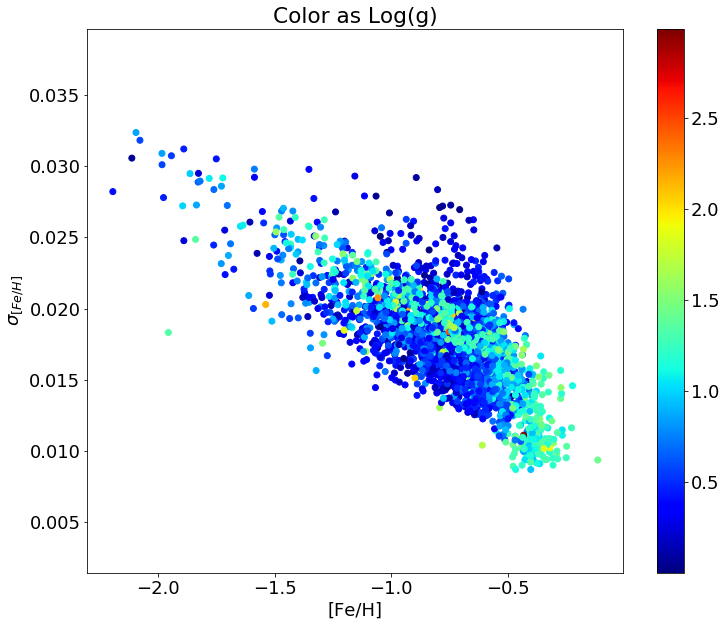

In [204]:
#########################
### Metallicity Error ###
#########################

plt.figure(figsize=[12,10])
plt.scatter(r13['FE_H'][np.where(r13['FE_H']>-9999.0)],r13['FE_H_ERR'][np.where(r13['FE_H']>-9999.0)],
            c=r13['LOGG'][np.where(r13['FE_H']>-9999.0)],cmap='jet')
plt.colorbar()
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'$\sigma_{[Fe/H]}$')
plt.title(r'Color as Log(g)')

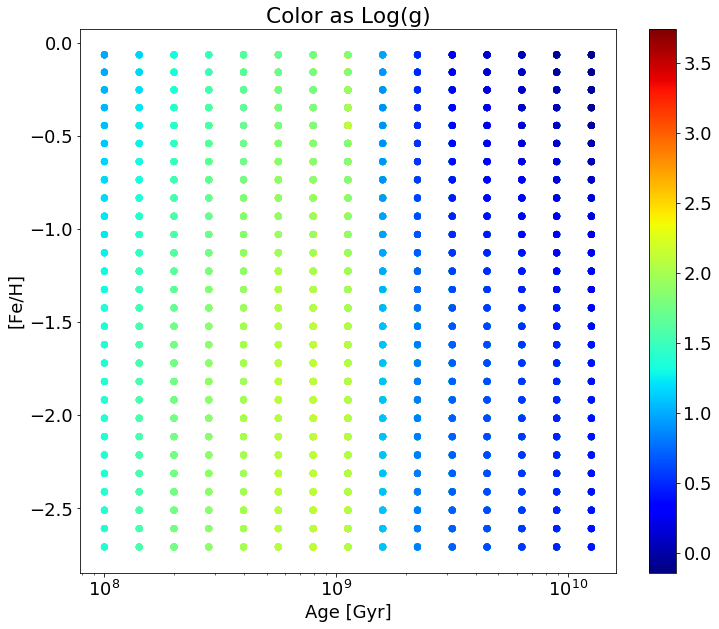

In [205]:
############################
### Age Metallicity Grid ###
############################

plt.figure(figsize=[12,10])
plt.scatter(10**parsec['logAge'],np.log10(parsec['Zini']/0.02),c=parsec['logg'],cmap='jet')
plt.xscale('log')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
plt.colorbar()
plt.title('Color as Log(g)')
plt.show()

In [8]:
import itertools as it

lt = parsec['logTe']
k = parsec['Ksmag']
feh = np.log10(parsec['Zini']/0.02)
lg  = parsec['logg']
ltk = np.multiply(lt,k)
ltfeh = np.multiply(lt,feh)
ltlg = np.multiply(lt,lg)
kfeh = np.multiply(k,feh)
klg = np.multiply(k,lg)
fehlg = np.multiply(feh,lg)
lt2 = lt**2
k2 = k**2
feh2 = feh**2
lg2 = lg**2

models = []
models_str = []
all_var_str = ['lt','k','feh','lg','ltk','ltfeh','ltlg','kfeh','klg','fehlg','lt2','k2','feh2','lg2']
all_var = [lt,k,feh,lg,ltk,ltfeh,ltlg,kfeh,klg,fehlg,lt2,k2,feh2,lg2]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='lt' and models_str[j][1]=='k' and models_str[j][2]=='feh' and models_str[j][3]=='lg':
        idx.append(j)
        
models = np.array(models)[idx]
models_str = np.array(models_str)[idx]

In [71]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

all_params = []
max_resid = []
gtest = []
mads = []
lae = []
stde = []
resids = []
predict = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - parsec['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    gtest.append(2*np.sum(predictions*np.log(np.divide(predictions,parsec['logAge']))))
    mads.append(afunc.mad(residual))
    lae.append(np.sum(np.absolute(residual)))
    stde.append(model.bse)


True


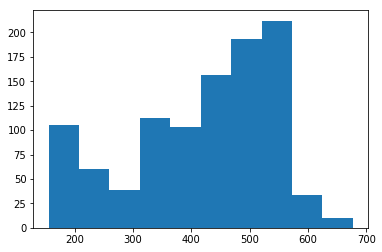

(array([992]),)


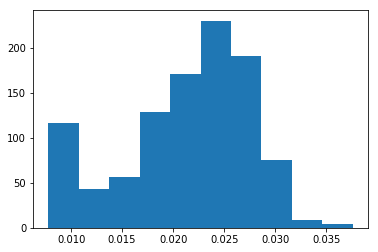

(array([992]),)


In [10]:
print(np.where(lae == min(lae)) == np.where(mads == min(mads)))

plt.hist(lae)
plt.show()
print(np.where(lae == min(lae)))
# print(models_str[992])

plt.hist(mads)
plt.show()
print(np.where(mads == min(mads)))
# print(models_str[992])

In [11]:
#########################
### Find lowest order ###
#########################

small = np.where(np.asarray(mads)<=0.01)

terms = []
for i in range(len(models_str[small])):
    terms.append(len(models_str[small][i]))
    
print(terms)
for j in range(7):
    print('index: ',np.arange(len(models_str))[small][j])
    print(models_str[small][j])

[9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14]
index:  506
['lt' 'k' 'feh' 'lg' 'ltk' 'klg' 'k2' 'feh2' 'lg2']
index:  606
['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'fehlg' 'k2' 'lg2']
index:  609
['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'lt2' 'k2' 'lg2']
index:  611
['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'k2' 'feh2' 'lg2']
index:  626
['lt' 'k' 'feh' 'lg' 'kfeh' 'klg' 'k2' 'feh2' 'lg2']
index:  635
['lt' 'k' 'feh' 'lg' 'klg' 'fehlg' 'k2' 'feh2' 'lg2']
index:  636
['lt' 'k' 'feh' 'lg' 'klg' 'lt2' 'k2' 'feh2' 'lg2']


In [14]:
print(np.asarray(all_params[606]))
print(np.asarray(models_str[606]))

[ 2.34865658e+01  7.73561422e-01  3.31229224e+00 -3.92253575e-02
 -4.71932940e+00 -8.67142123e-01 -6.83193259e-01  1.93831669e-02
  1.39372987e-01  8.31208860e-01]
['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'fehlg' 'k2' 'lg2']


In [16]:
def find_age(lt,k,feh,lg):
    #['lt' 'k' 'feh' 'lg' 'ltk' 'ltfeh' 'kfeh' 'klg' 'fehlg' 'k2' 'feh2' 'lg2']
#     p = [2.07483027e+01,1.25330396e+00,4.38762008e+00,3.15757396e+00,-6.92771748e+00,-3.98506724e-01,-8.32023943e-01,-8.80250421e-03,-5.27532676e-01,5.78640717e-02,1.16480914e-01,4.97348135e-02,6.19034227e-01]
#     age = p[0] + p[1]*lt + p[2]*k + p[3]*feh + p[4]*lg + p[5]*np.multiply(lt,k) + p[6]*np.multiply(lt,feh) + p[7]*np.multiply(k,feh) + p[8]*np.multiply(k,lg) + p[9]*np.multiply(feh,lg) + p[10]*np.square(k) + p[11]*np.square(feh) + p[12]*np.square(lg) 
#     return age
    #['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'fehlg' 'k2' 'lg2']
    p = [2.34865658e+01,7.73561422e-01,3.31229224e+00,-3.92253575e-02,-4.71932940e+00,
         -8.67142123e-01,-6.83193259e-01,1.93831669e-02,1.39372987e-01,8.31208860e-01]
    age = p[0] + p[1]*lt + p[2]*k + p[3]*feh + p[4]*lg + p[5]*np.multiply(lt,lg) + p[6]*np.multiply(k,lg) + p[7]*np.multiply(feh,lg) + p[8]*np.square(k) + p[9]*np.square(lg)
    return age

In [17]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE']+r13['FE_H']-r13['M_H']))
    x_N.append(sol_xm[1]*10**(r13['N_FE']+r13['FE_H']-r13['M_H']))
    x_O.append(sol_xm[2]*10**(r13['O_FE']+r13['FE_H']-r13['M_H']))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE']+r13['FE_H']-r13['M_H']))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE']+r13['FE_H']-r13['M_H']))
    x_S.append(sol_xm[5]*10**(r13['S_FE']+r13['FE_H']-r13['M_H']))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE']+r13['FE_H']-r13['M_H']))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H']-r13['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

_, _, stardist = afunc.LMCdisk_cart(r13['RA'],r13['DEC'])
corabsK = afunc.absmag(r13['K'],stardist)-r13['AK_TARG']
parage = find_age(np.log10(r13['TEFF']),corabsK,afunc.sal(r13['M_H'],metscorr),r13['LOGG'])
# parage = find_age(np.log10(r13['TEFF']),corabsK,r13['LOGG']) #,sal(r13['M_H'],r13['ALPHA_M'])


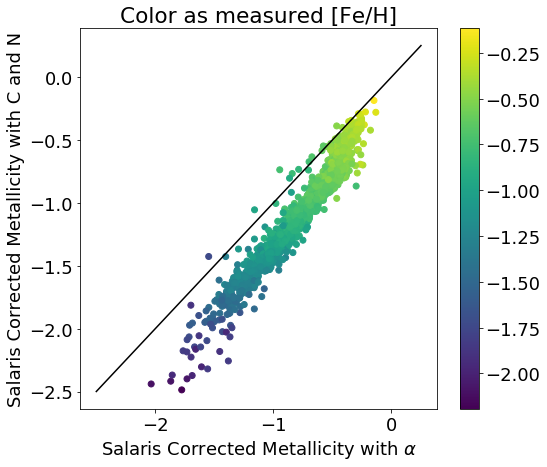

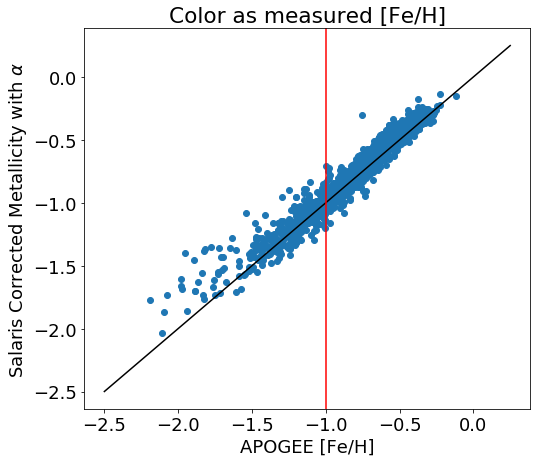

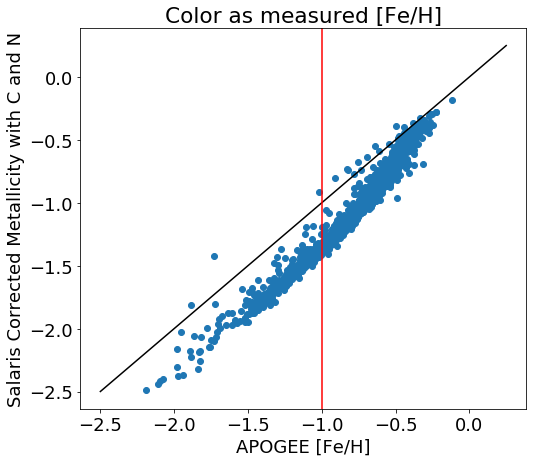

In [229]:
plt.figure(figsize=[8,7])
plt.scatter(afunc.sal(r13['M_H'],r13['ALPHA_M']),afunc.sal(r13['M_H'],metscorr),c=r13['FE_H'])
plt.colorbar()
plt.plot([-2.5,0.25],[-2.5,0.25],c='k')
plt.xlabel(r'Salaris Corrected Metallicity with $\alpha$')
plt.ylabel(r'Salaris Corrected Metallicity with C and N')
plt.title(r'Color as measured [Fe/H]')
plt.show()

plt.figure(figsize=[8,7])
plt.scatter(r13['FE_H'],afunc.sal(r13['M_H'],r13['ALPHA_M']))
plt.plot([-2.5,0.25],[-2.5,0.25],c='k')
plt.axvline(-1.0,c='r')
plt.xlabel(r'APOGEE [Fe/H]')
plt.ylabel(r'Salaris Corrected Metallicity with $\alpha$')
plt.title(r'Color as measured [Fe/H]')
plt.show()

plt.figure(figsize=[8,7])
plt.scatter(r13['FE_H'],afunc.sal(r13['M_H'],metscorr))
plt.plot([-2.5,0.25],[-2.5,0.25],c='k')
plt.axvline(-1.0,c='r')
plt.xlabel(r'APOGEE [Fe/H]')
plt.ylabel(r'Salaris Corrected Metallicity with C and N')
plt.title(r'Color as measured [Fe/H]')
plt.show()

In [117]:
kasc.columns

ColDefs(
    name = 'KEPLER_ID'; format = '20A'
    name = 'KEPLER_INT'; format = 'K'
    name = '2MASS_ID'; format = '20A'
    name = 'LOC_ID'; format = '20A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'RA_PM'; format = 'D'
    name = 'DEC_PM'; format = 'D'
    name = 'UCAC_PM_RA'; format = 'E'
    name = 'UCAC_PM_RA_ERR'; format = 'E'
    name = 'UCAC_PM_DEC'; format = 'E'
    name = 'UCAC_PM_DEC_ERR'; format = 'E'
    name = 'GAIA_L'; format = 'E'
    name = 'GAIA_B'; format = 'E'
    name = 'GAIA_ECLIPTIC_LONGITUDE'; format = 'E'
    name = 'GAIA_ECLIPTIC_LATITUTE'; format = 'E'
    name = 'GAIA_PARALLAX'; format = 'E'; unit = 'Angle[mas]'
    name = 'GAIA_PARALLAX_ERR'; format = 'E'; unit = 'Angle[mas]'
    name = 'GAIA_SOURCE_ID_DR2'; format = '23A'
    name = 'GAIA_PARALLAX_DR2'; format = 'D'
    name = 'GAIA_PARALLAX_ERROR_DR2'; format = 'D'
    name = 'GAIA_PMRA_DR2'; format = 'D'
    name = 'GAIA_PMRA_ERROR_DR2'; format = 'D'
    name = 'GAIA_PMDE

In [155]:
min(r13['K'])

12.068

(array([2.184e+03, 2.810e+02, 8.900e+01, 1.200e+01, 1.000e+01, 9.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00091767, 0.05909959, 0.1172815 , 0.17546342, 0.23364533,
        0.29182726, 0.35000917, 0.40819108, 0.46637303, 0.5245549 ,
        0.58273685], dtype=float32),
 <a list of 10 Patch objects>)

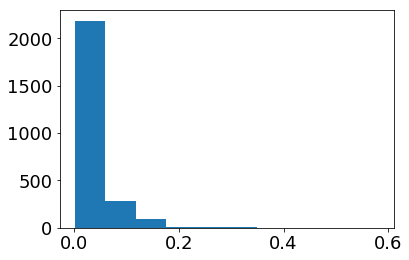

In [157]:
plt.hist(r13['AK_TARG'])

(array([394., 910., 471., 267., 219., 115.,  82.,  64.,  52.,  14.]),
 array([12.068    , 12.315    , 12.562    , 12.809    , 13.056    ,
        13.3029995, 13.55     , 13.797    , 14.044    , 14.291    ,
        14.538    ], dtype=float32),
 <a list of 1 Patch objects>)

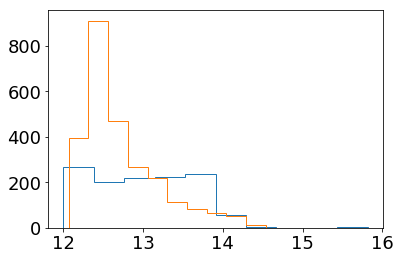

In [164]:
plt.hist(kasc['K_MAG_2M'][kasc['K_MAG_2M']>12.0],histtype='step')
plt.hist(r13['K'],histtype='step')

(array([5.30e+01, 1.57e+02, 2.22e+02, 6.38e+02, 1.08e+03, 4.11e+02,
        2.10e+01, 5.00e+00, 0.00e+00, 1.00e+00]),
 array([ 7.18225512,  7.81983576,  8.45741639,  9.09499703,  9.73257767,
        10.3701583 , 11.00773894, 11.64531958, 12.28290021, 12.92048085,
        13.55806149]),
 <a list of 1 Patch objects>)

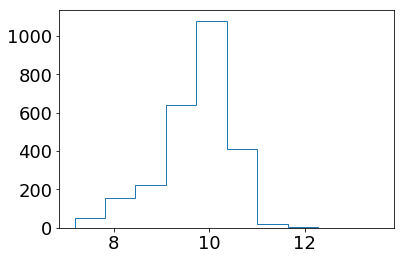

In [162]:
plt.hist(parage,histtype='step')

## Random Error

In [19]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [236]:
####################################
### Get Uncertainties: Add Noise ###
####################################

def add_noise(quant,quant_err):
    '''
    Add noise to data and return new values
    
    Parameters:
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
    
    return: 1d array-like object of data with added noise
    
    '''
    
    noise = np.random.normal(0,quant_err)
    new = quant + noise
    return new

def add_pos_noise(quant,quant_err):
    '''
    Add noise to data and return new values that are only positive
    
    Parameters:
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
    
    return: 1d array-like object of data with added noise
    
    '''
    
    noise = np.absolute(np.random.normal(0,quant_err))
    new = quant + noise
    return new

def sal_noise(cfe,cfeERR,nfe,nfeERR,feh,fehERR,mh,mhERR):
    '''
    Calculate noisy values for Salaris calculation with C and N.
    This does not take into account actually plugging in [M/H],
    for that use add_noise.
    
    Parameters:
        cfe: 1d array-like object of carbon abundances
        cfeERR: 1d array-like object of carbon abundance errors
        nfe: 1d array-like object of nitrogen abundances
        nfeERR: 1d array-like object of nitrogen abundance errors
        feh: 1d array-like object of iron abundances
        fehERR: 1d array-like object of iron abundance errors
        
    Return:
        noisy Salaris correction ffac
    '''
    
    sol_C = 0.28115244582676185 #solar carbon abundance
    sol_N = 0.06901474154376043 #solar nitrogen abundance
    
    # Calculate [C/M] and [N/M] with respective errors
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    # Calculate X fractions for C and N with respective errors
    x_C = sol_C*10**(cm)
    x_N = sol_N*10**(nm)
    
    x_CERR = 10**(cm)*np.log(10)*CMERR
    x_NERR = 10**(nm)*np.log(10)*NMERR
    
    # Calcuate f factor in Salaris correction with respective errors
    ffac = (x_C+x_N)/(sol_C+sol_N) #factor from Salaris correction
    ffacERR = np.sqrt((x_CERR)**2+(x_NERR)**2)/(sol_C+sol_N)
    
    # Add noise to calculated f factor
    ffacnoise = np.random.normal(0, np.absolute(0.434*(ffacERR/ffac))) 
    
    return ffac + ffacnoise

In [20]:
# #######################################
# ### Get Uncertainties: Random Error ###
# #######################################

# randdevs = []

# for i in tqdm_notebook(range(len(r13)),desc='Done?',leave=False):
#     lgT = np.log10(r13['TEFF'][i])
#     lgTERR = 0.434*(np.log(r13['TEFF_ERR'][i])/np.log10(r13['TEFF'][i]))
#     ks = corabsK[i]
#     ksERR = r13['K_ERR'][i]
#     mh = r13['M_H'][i]
#     mhERR = r13['M_H_ERR'][i]
#     cfe = r13['C_FE'][i]
#     cfeERR = r13['C_FE_ERR'][i]
#     nfe = r13['N_FE'][i]
#     nfeERR = r13['N_FE_ERR'][i]
#     feh = r13['FE_H'][i]
#     fehERR = r13['FE_H_ERR'][i]
#     lgg = r13['LOGG'][i]
#     lggERR = r13['LOGG_ERR'][i]
    
#     ages = []
#     for j in range(1000):
#         nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
#                                           fehERR,lgg,lggERR)
#         ages.append(find_age(nlgT,nks,afunc.sal(nmh,nfac),nlgg))
    
#     randdevs.append(afunc.mad(ages))

In [238]:
################################
### Calculate  Uncertainties ###
################################

devs = []
halo_cutoff = -2.0

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR']
    
    noise_ages = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        if feh <= halo_cutoff:
            dist_new = add_pos_noise(dist,1.0)
            absK_new = afunc.absmag(ks_new,dist_new) - ak
        
        else:
            absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        ffac_new = sal_noise(cfe,cfe_err,nfe,nfe_err,feh,feh_err,mh,mh_err)
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        noise_ages.append(find_age(np.log10(teff_new),absK_new,afunc.sal(mh_new,ffac_new),lgg_new))
    
    devs.append(afunc.mad(noise_ages))

(array([394., 910., 471., 267., 219., 115.,  82.,  64.,  52.,  14.]),
 array([12.068    , 12.315    , 12.562    , 12.809    , 13.056    ,
        13.3029995, 13.55     , 13.797    , 14.044    , 14.291    ,
        14.538    ], dtype=float32),
 <a list of 1 Patch objects>)

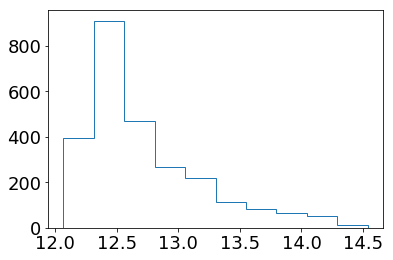

In [161]:
plt.hist(r13['K'],histtype='step')

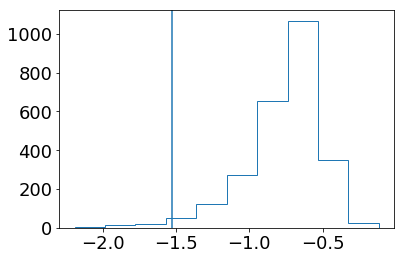

In [160]:
plt.hist(r13['FE_H'],histtype='step')
plt.axvline(-1.53)

In [217]:
len(np.squeeze(np.where(parage>=np.log10(ageU)+np.max(devs))))/len(parage)

0.19088098918083463

In [218]:
max(parage)
ageU+np.max(devs)

13208053784.797043

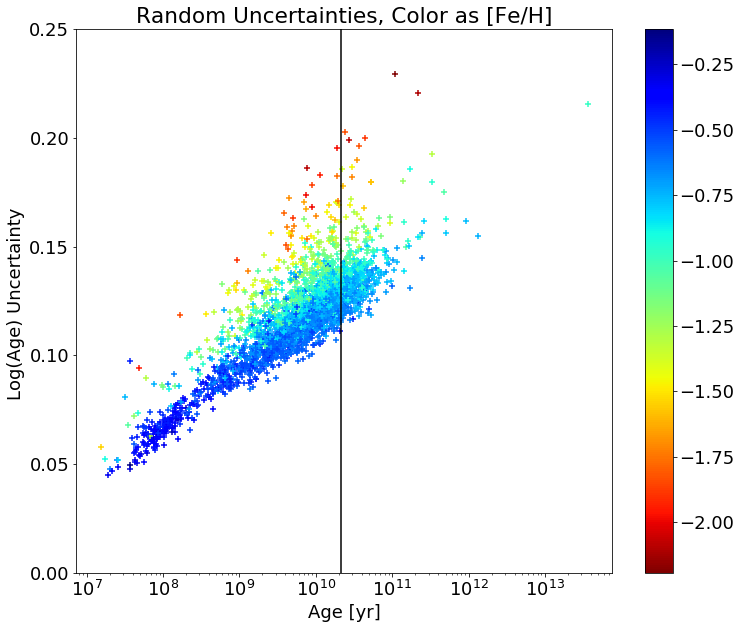

In [239]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parage),randdevs,marker='+',c=r13['FE_H'],cmap='jet_r')
plt.colorbar()
plt.axvline(10**(np.log10(ageU)+np.max(devs)),c='k')
plt.xscale('log')
plt.ylim(0,0.25)
plt.title(r'Random Uncertainties, Color as [Fe/H]')
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty ')
plt.show()

0.3535533905932738

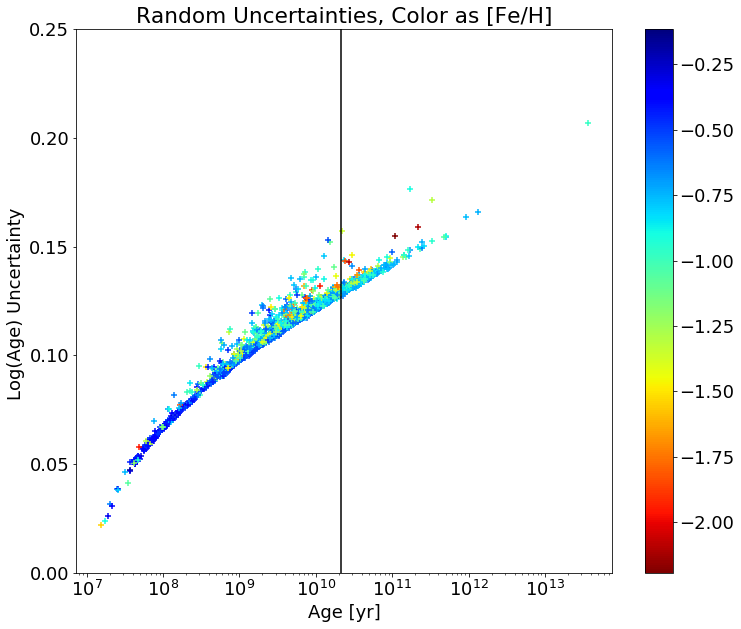

In [240]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parage),devs,marker='+',c=r13['FE_H'],cmap='jet_r')
plt.colorbar()
plt.axvline(10**(np.log10(ageU)+np.max(devs)),c='k')
plt.xscale('log')
plt.ylim(0,0.25)
plt.title(r'Random Uncertainties, Color as [Fe/H]')
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty ')
plt.show()

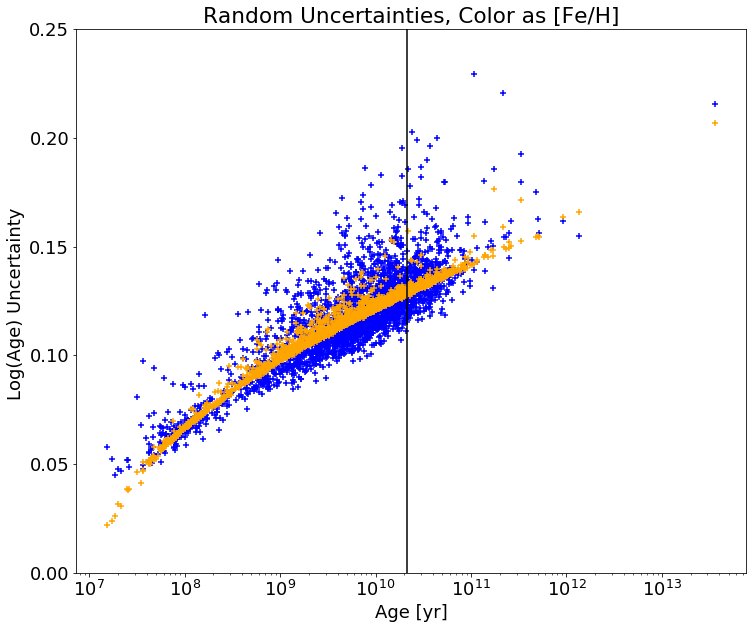

In [241]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parage),randdevs,marker='+',c='blue')
plt.scatter(10**np.asarray(parage),devs,marker='+',c='orange')
plt.axvline(10**(np.log10(ageU)+np.max(devs)),c='k')
plt.xscale('log')
plt.ylim(0,0.25)
plt.title(r'Random Uncertainties, Color as [Fe/H]')
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty ')
plt.show()

APOKASC

Diane's age paper

metal poor stars thin disk plane might have diff geo puffed up so sys dist uncert could say if dist off by this what age uncert this give 1 kpc out of plane

In [42]:
#####################################
### Get Uncertainties: Systematic ###
#####################################

#['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'fehlg' 'k2' 'lg2']
def noisyparams(params,params_err):
    const_noise = np.random.normal(0,params_err[0])
    lt_noise = np.random.normal(0,params_err[1])
    k_noise = np.random.normal(0,params_err[2])
    feh_noise = np.random.normal(0,params_err[3])
    lg_noise = np.random.normal(0,params_err[4])
    
    ltlg_noise = np.random.normal(0,params_err[5])
    klg_noise = np.random.normal(0,params_err[6])
    fehlg_noise = np.random.normal(0,params_err[7])
    
    k2_noise = np.random.normal(0,params_err[8])
    lg2_noise = np.random.normal(0,params_err[9])
    
    constnew = params[0] + ((-1)**np.random.randint(2))*const_noise
    ltnew = params[1] + ((-1)**np.random.randint(2))*const_noise
    knew = params[2] + ((-1)**np.random.randint(2))*const_noise
    fehnew = params[3] + ((-1)**np.random.randint(2))*const_noise
    lgnew = params[4] + ((-1)**np.random.randint(2))*const_noise
    
    ltlgnew = params[5] + ((-1)**np.random.randint(2))*const_noise
    klgnew = params[6] + ((-1)**np.random.randint(2))*const_noise
    fehlgnew = params[7] + ((-1)**np.random.randint(2))*const_noise
    
    k2new = params[8] + ((-1)**np.random.randint(2))*const_noise
    lg2new = params[9] + ((-1)**np.random.randint(2))*const_noise
    
    newparams = [constnew,ltnew,knew,fehnew,lgnew,ltlgnew,klgnew,fehlgnew,k2new,lg2new]
    
    return newparams

def sys_find_age(lt,k,feh,lg,params):
    #['lt' 'k' 'feh' 'lg' 'ltlg' 'klg' 'fehlg' 'k2' 'lg2']
    age = params[0] + params[1]*lt + params[2]*k + params[3]*feh + params[4]*lg + params[5]*np.multiply(lt,lg) + params[6]*np.multiply(k,lg) + params[7]*np.multiply(feh,lg) + params[8]*np.square(k) + params[9]*np.square(lg)
    return age
    

In [45]:
#####################################
### Get Uncertainties: Systematic ###
#####################################

sysdevs = []

for i in tqdm_notebook(range(len(r13)),desc='Done?',leave=False):
    lgT = np.log10(r13['TEFF'][i])
#     lgTERR = 0.434*(np.log(r13['TEFF_ERR'][i])/np.log10(r13['TEFF'][i]))
    ks = corabsK[i]
#     ksERR = r13['K_ERR'][i]
    mh = r13['M_H'][i]
#     mhERR = r13['M_H_ERR'][i]
#     cfe = r13['C_FE'][i]
#     cfeERR = r13['C_FE_ERR'][i]
#     nfe = r13['N_FE'][i]
#     nfeERR = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
#     fehERR = r13['FE_H_ERR'][i]
    lgg = r13['LOGG'][i]
#     lggERR = r13['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        newthings = noisyparams(all_params[606],stde[606])
        ages.append(sys_find_age(lgT,ks,afunc.sal(mh,metscorr),lgg,newthings))
    
    sysdevs.append(afunc.mad(ages))

In [48]:
print(stde[606])

[0.11950369 0.03312547 0.00826747 0.00112454 0.05497575 0.01591917
 0.00262797 0.0005067  0.00049528 0.00377418]


(array([ 34.,  66., 100., 160., 251., 348., 656., 727., 211.,  35.]),
 array([0.97727776, 1.2447494 , 1.5122211 , 1.7796929 , 2.0471644 ,
        2.3146362 , 2.582108  , 2.8495796 , 3.1170514 , 3.384523  ,
        3.6519947 ], dtype=float32),
 <a list of 10 Patch objects>)

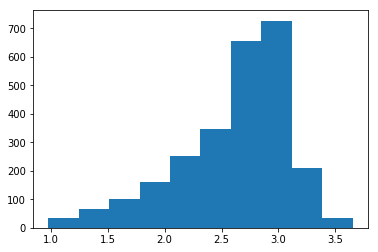

In [46]:
plt.hist(sysdevs)

In [ ]:
plt.hist(parage,range(0,15))
plt.axvline(10.13+np.median(devs),c='r')

In [ ]:
len(np.squeeze(np.where(parage>=10.13+np.median(devs))))/len(parage)

In [ ]:
plt.scatter(r13['M_H'] + np.log(0.638*(10**(r13['ALPHA_M']))+0.362),sal(r13['M_H'],metscorr))
plt.plot([-3,-2,-1,0,1],[-3,-2,-1,0,1],c='k')

In [ ]:
plt.hist(10**parsec['logAge'])
plt.xscale('log')

In [57]:
len(all_params[606])

10

(array([  1.,   1.,   5.,   8.,  49., 266., 315., 509., 916., 518.]),
 array([0.17291006, 0.1987787 , 0.22464733, 0.25051597, 0.2763846 ,
        0.30225324, 0.32812187, 0.35399051, 0.37985915, 0.40572778,
        0.43159642]),
 <a list of 10 Patch objects>)

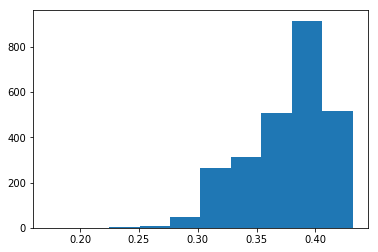

In [98]:
df_dlt = all_params[606][1] + all_params[606][5]*r13['LOGG']
df_dk = all_params[606][2] + 2*all_params[606][8]*corabsK
df_dfeh = all_params[606][3] + all_params[606][7]*r13['LOGG']
df_dlg = all_params[606][4] + all_params[606][7]*afunc.sal(r13['M_H'],metscorr) + 2*all_params[606][9]*r13['LOGG'] + all_params[606][5]*np.log10(r13['TEFF'])

variance = np.multiply(df_dlt**2,stde[606][1]**2) + np.multiply(df_dk**2,stde[606][2]**2) + np.multiply(df_dfeh**2,stde[606][3]**2) + np.multiply(df_dlg**2,stde[606][4]**2)


plt.hist(np.sqrt(variance))

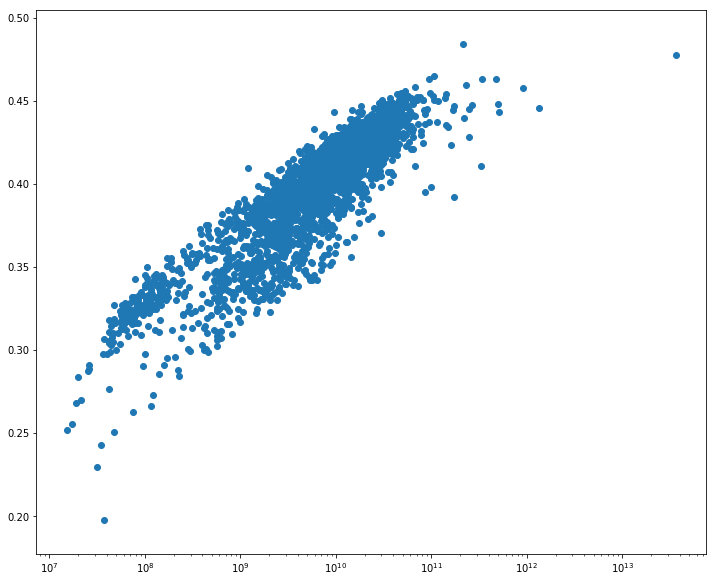

In [69]:
plt.figure(figsize=[12,10])
plt.scatter(10**parage,np.sqrt(variance+np.square(randdevs)))
plt.xscale('log')

In [66]:
np.median(np.sqrt(variance+np.square(randdevs)))

len(np.squeeze(np.where(parage>=10.13+np.median(np.sqrt(variance+np.square(randdevs))))))/len(parage)

0.08809891808346214

## Grid interpolator

In [ ]:
from scipy.interpolate import NearestNDInterpolator, RegularGridInterpolator, LinearNDInterpolator


In [ ]:
X = np.array([y1,y2,y3,y4]).T
y = parsec['logAge']

myInterpolator = LinearNDInterpolator(X, y)

In [ ]:
lt = np.log10(r13['TEFF'])
k = corabsK
feh = sal(r13['M_H'],np.squeeze(metscorr))
lg = r13['LOGG']

ages = []
for i in range(len(r13)):
    ages.append(myInterpolator(lt[i],k[i],feh[i],lg[i]))

In [ ]:
plt.hist(10**np.asarray(ages)/10**9)

In [ ]:
np.nanmax(10**np.asarray(ages)/10**9)

In [ ]:
print(np.squeeze(np.where(np.isfinite(10**np.asarray(ages)/10**9)==False)).data)